# 1. Import Dependencies

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import os
import time


## Loading Dataset

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

The training and testing datasets are loaded into seperate numpy arrays.

We are interested in generating a single digit, for example 5, so we extract all images containing 5 from the dataset.

In [3]:
digit5_images = []
for i in range(len(train_images)):
    if train_labels[i] == 5:
        digit5_images.append(train_images[i])
train_images = np.array(digit5_images)
train_images.shape

# The output shape is (5421, 28, 28) so we have 5421 images of size 28 x 28 

(5421, 28, 28)

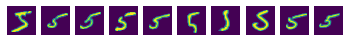

In [4]:
# Verify we only have images contianing the digit 5

n= 10
f = plt.figure()
for i in range(n):
    f.add_subplot(1, n, i+1)
    plt.subplot(1, n, i+1).axis('off')
    plt.imshow(train_images[i])
plt.show()

### Preparing Dataset

In [5]:
# First we reshaped the data 
train_images = train_images.reshape(
    train_images.shape[0], 28, 28, 1).astype('float32')

# As each colour in the images is in the range from 0 to 256, we normalise the values between -1 and 1.
# The mean is 127.5 and the numbers are normalised as follows:

train_images = (train_images - 127.5) / 127.5

# We crate a batch dataset for training by calling the from_tensor_slices method

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(32)

### Defining a Generator Model
The generator's purpose is to create images containing the digit 5 which look similar to the images in our training dataset.

In [6]:
# Creating a Keras sequential model

gen_model = tf.keras.Sequential()

# Add a dense layer as the first layer
gen_model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
# The input to this layer has been specified as 100 because later a noise vector of dimension 100 will
# will be used as an input to this GAN model.

# Next add a batch normalization layer to the model for providing stability.
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())

#  Reshape the output to 7x7x256
gen_model.add(tf.keras.layers.Reshape((7, 7, 256)))

# Use a Conv2D layer to upscale the generated image
gen_model.add(tf.keras.layers.Conv2DTranspose(
    128, (5, 5),
    strides = (1,1),
    padding = 'same',
    use_bias = False))

# Batch normalization and activation layers as before
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())

# Next a Conv2DTrasnpose layer with strides set to (2,2) is added followed by the batch normalization 
# and activation layers
gen_model.add(tf.keras.layers.Conv2DTranspose(
    64, (5 ,5),
    strides = (2,2),
    padding='same',
    use_bias=False))

gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())

# The final Conv 2D layer with strides queal to (2,2) is now added, further upscaling the image size to 28x28
gen_model.add(tf.keras.layers.Conv2DTranspose(
    1, (5,5),
    strides=(2,2),
    padding='same',
    use_bias=False,
    activation='tanh'))

gen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

### Testing Generator

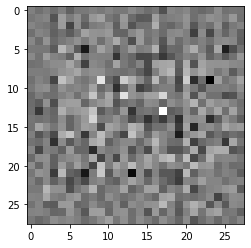

In [7]:
# Testing the generator with a random input vector and display it
noise = tf.random.normal([1, 100])
generated_image = gen_model(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [8]:
# Check the shape of the image
generated_image.shape

TensorShape([1, 28, 28, 1])

### Defining the Discriminator Model

In [9]:
descri_model = tf.keras.Sequential()
descri_model.add(tf.keras.layers.Conv2D(
    64, (5,5),
    strides=(2,2),
    padding='same',
    input_shape=[28, 28, 1]))

descri_model.add(tf.keras.layers.LeakyReLU())
descri_model.add(tf.keras.layers.Dropout(0.3))
descri_model.add(tf.keras.layers.Conv2D(
    128, (5,5),
    strides=(2,2),
    padding='same'))

descri_model.add(tf.keras.layers.LeakyReLU())
descri_model.add(tf.keras.layers.Dropout(0.3))
descri_model.add(tf.keras.layers.Flatten())
descri_model.add(tf.keras.layers.Dense(1))

# The descriminator uses just two convolutional layers. The output of the last convolutional layer
# is of tyle (batch size, height, width, filters). The Flatten layer in the network flattens this
# output to feed it to the last Dense layer in the network.

descri_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [10]:
# Testing the discriminator

decision = descri_model(generated_image)
print(decision)

tf.Tensor([[0.00196577]], shape=(1, 1), dtype=float32)


## Defining Loss Functions

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Binary cross entropy used as we have two classes (1) for a real image and (0) for a fake one

In [12]:
# The generator loss is defined as:
def generator_loss(generated_output):
    return cross_entropy(tf.ones_like(generated_output), generated_output)

In [13]:
# The discriminator loss is defined as:
def discriminator_loss(real_output, generated_output):
    
    # compute the loss considering the image  is real [1, 1, ..., 1]
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # compute loss considering the image is fake [0, 0, ...,0]
    generated_loss = cross_entropy(tf.zeros_like(generated_output), generated_output)

    # compute total loss

    total_loss = real_loss + generated_loss

    return total_loss

In [14]:
# Defining the optimizers for both generator and discriminator
gen_optimizer = tf.optimizers.Adam(1e-4)
discri_optimizer = tf.optimizers.Adam(1e-4)

In [15]:
# Defining a few variables for training
epoch_number = 0
EPOCHS = 100
noise_dim = 100
seed = tf.random.normal([1, noise_dim])


## Checkpoint setup
As the model training may take a long time intermediate states of the generator and discriminator are saved to a local file

In [17]:
checkpoint_dir = '/checkpoints/checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')

checkpoint = tf.train.Checkpoint(generator_optimizer = gen_optimizer, discriminator_optimizer=discri_optimizer,
generator=gen_model,
discriminator=descri_model)

### Model Training Setup
Both the generator and discriminator will be trained in several steps. 

Gradient tape (tf.GradientTape) is used for automatic differentiation on both the generator and discriminator.

At each step, a batch of images are given to the function as an input. The discriminator is asked to produce outputs for both the training and generated images. The training output is called as real and the generated image output as fake. The generator loss and discriminator loss is calculated on both the real and fake. Gradient tape is then used to compute the gradients on both losses and the apply the new gradients to the models.

In [18]:
def gradient_tuning(images):
    # create a noise vector
    noise = tf.random.normal([16, noise_dim])

    #Use gradient tapes for automatic differentiation
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        
        # ask generator to generate random images
        generated_images = gen_model(noise, training=True)

        # ask discriminator to evaluate real images and generate its output
        real_output =   descri_model(images, training=True)

        # ask discriminator to do the evaluatiion on generated (fake) images
        fake_output = descri_model(generated_images, training=True)
        
        # calcualte generator loss on fake data
        gen_loss = generator_loss(fake_output)

        # calculate discriminator loss as defined earlier
        disc_loss = discriminator_loss(real_output,fake_output)

    # calculate gradients for generator
    gen_gradients = generator_tape.gradient(gen_loss, gen_model.trainable_variables)

    # calculate gradients for discriminator
    discri_gradients = discriminator_tape.gradient(disc_loss, descri_model.trainable_variables)

    # use optimizer to process and apply gradients to variables
    gen_optimizer.apply_gradients(zip(gen_gradients, gen_model.trainable_variables))

    # same as above to discriminator
    discri_optimizer.apply_gradients(zip(discri_gradients, descri_model.trainable_variables))




In [19]:
def generate_and_save_images(model, epoch, test_input):
   
    global epoch_number
    epoch_number = epoch_number + 1
   
    # set training to false to ensure inference mode predictions
    predictions = model(test_input, training=False)

    # display and save image
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

    plt.savefig('image_at_epoch_{:01d}.png'.format(epoch_number))
    plt.show()


In [20]:
# model training function
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gradient_tuning(image_batch)
        
        # produce images as we go
        generate_and_save_images(gen_model, epoch +1, seed)

        #save checkpoint data
        checkpoint.save(file_prefix = checkpoint_prefix)
        print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

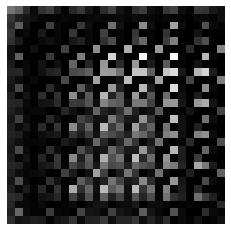

Time for epoch 1 is 33.70309638977051 sec


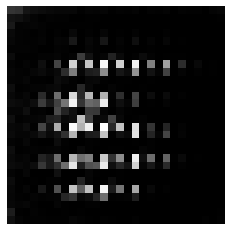

Time for epoch 2 is 32.14985179901123 sec


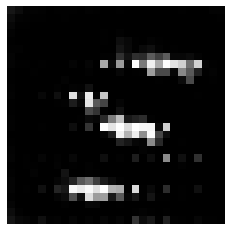

Time for epoch 3 is 31.05624222755432 sec


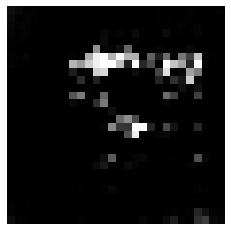

Time for epoch 4 is 28.453932285308838 sec


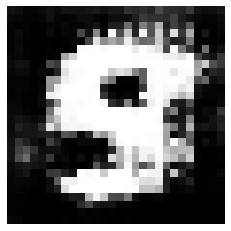

Time for epoch 5 is 33.94806456565857 sec


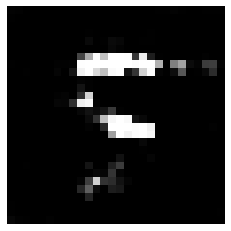

Time for epoch 6 is 32.193681478500366 sec


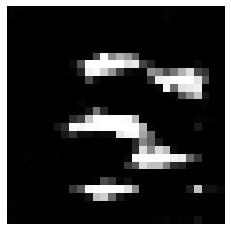

Time for epoch 7 is 32.70450758934021 sec


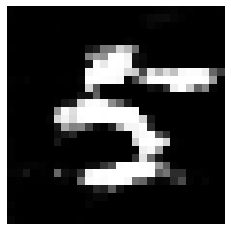

Time for epoch 8 is 33.255871057510376 sec


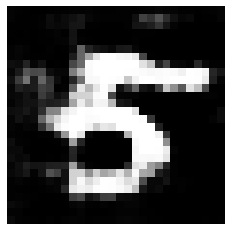

Time for epoch 9 is 32.50390005111694 sec


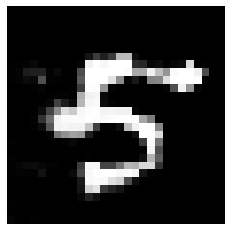

Time for epoch 10 is 28.675456285476685 sec


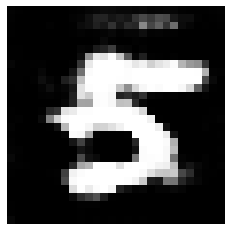

Time for epoch 11 is 29.875041246414185 sec


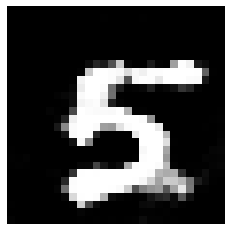

Time for epoch 12 is 28.75211215019226 sec


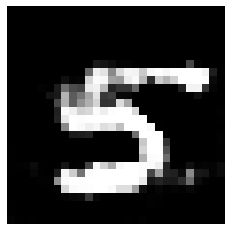

Time for epoch 13 is 28.695117473602295 sec


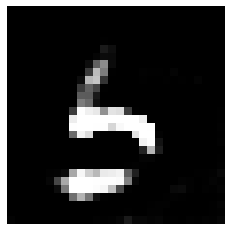

Time for epoch 14 is 28.458092212677002 sec


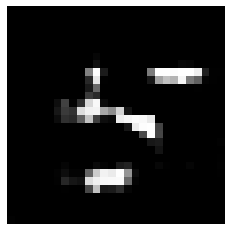

Time for epoch 15 is 31.33427143096924 sec


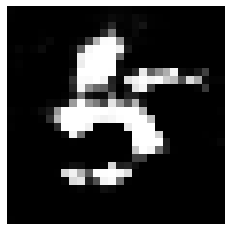

Time for epoch 16 is 46.53339433670044 sec


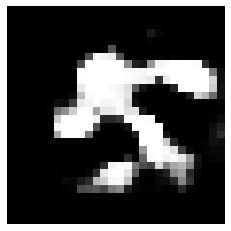

Time for epoch 17 is 32.53598666191101 sec


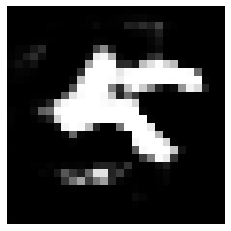

Time for epoch 18 is 34.940919399261475 sec


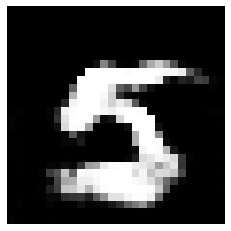

Time for epoch 19 is 49.436115026474 sec


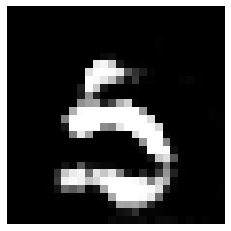

Time for epoch 20 is 39.49254059791565 sec


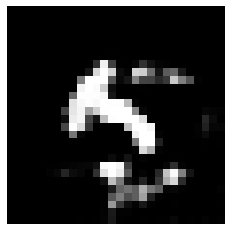

Time for epoch 21 is 28.15225052833557 sec


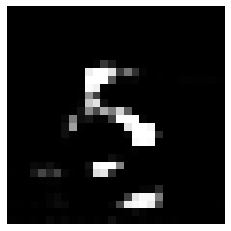

Time for epoch 22 is 28.82263159751892 sec


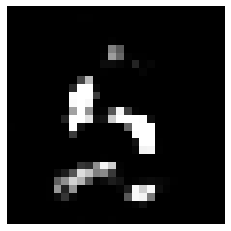

Time for epoch 23 is 30.50534987449646 sec


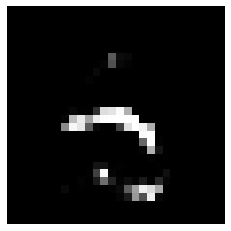

Time for epoch 24 is 29.243448495864868 sec


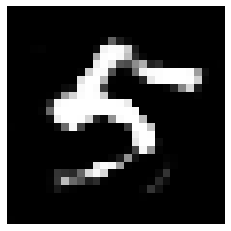

Time for epoch 25 is 28.552390813827515 sec


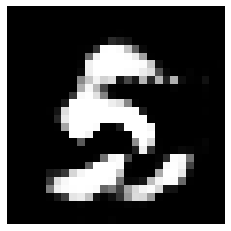

Time for epoch 26 is 28.000550508499146 sec


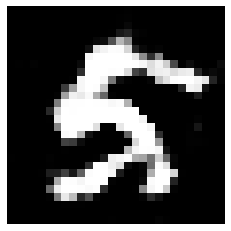

Time for epoch 27 is 28.12135100364685 sec


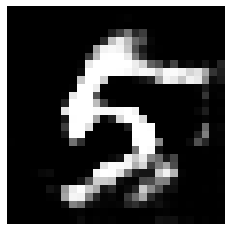

Time for epoch 28 is 28.11910057067871 sec


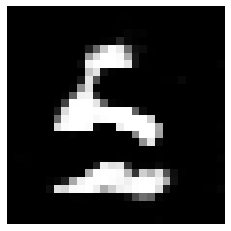

Time for epoch 29 is 31.49212670326233 sec


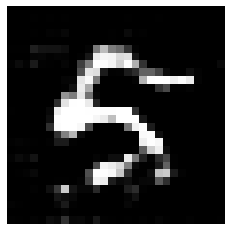

Time for epoch 30 is 28.467530488967896 sec


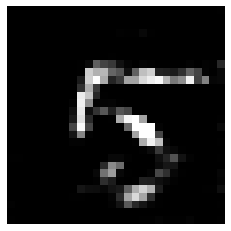

Time for epoch 31 is 28.331814527511597 sec


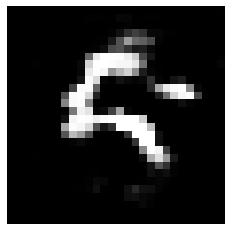

Time for epoch 32 is 28.419020414352417 sec


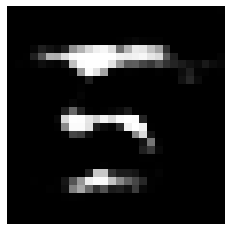

Time for epoch 33 is 29.11348271369934 sec


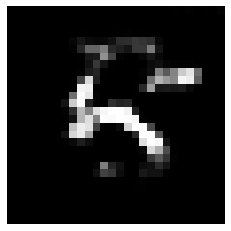

Time for epoch 34 is 31.69902801513672 sec


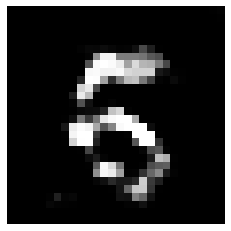

Time for epoch 35 is 32.630393505096436 sec


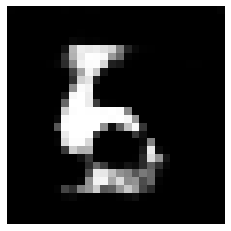

Time for epoch 36 is 30.407072067260742 sec


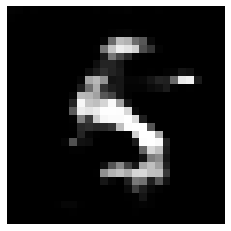

Time for epoch 37 is 33.722792863845825 sec


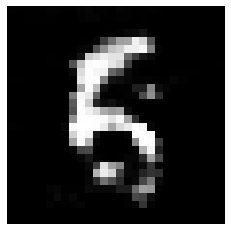

Time for epoch 38 is 38.166080951690674 sec


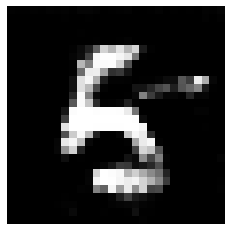

Time for epoch 39 is 42.00502681732178 sec


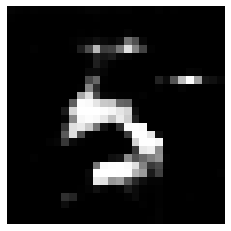

Time for epoch 40 is 33.63977074623108 sec


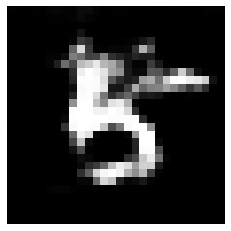

Time for epoch 41 is 29.296416521072388 sec


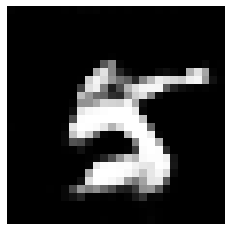

Time for epoch 42 is 29.804471731185913 sec


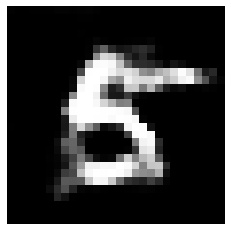

Time for epoch 43 is 34.47237730026245 sec


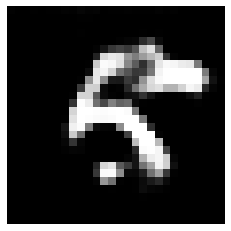

Time for epoch 44 is 30.322414875030518 sec


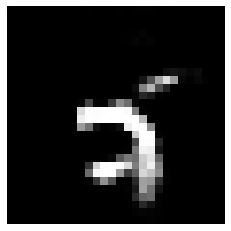

Time for epoch 45 is 29.352193117141724 sec


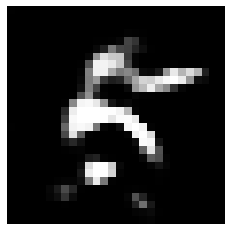

Time for epoch 46 is 28.9758620262146 sec


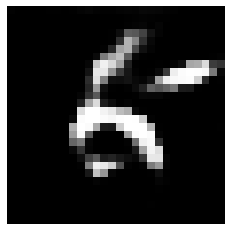

Time for epoch 47 is 29.382988214492798 sec


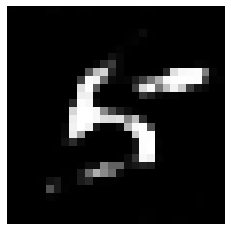

Time for epoch 48 is 29.087655782699585 sec


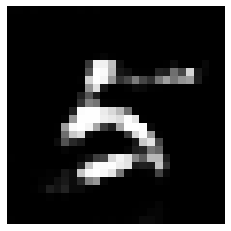

Time for epoch 49 is 29.624934196472168 sec


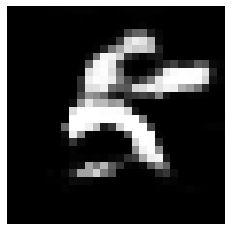

Time for epoch 50 is 30.816493034362793 sec


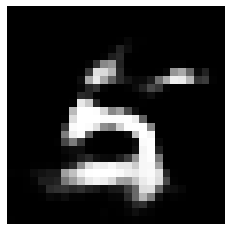

Time for epoch 51 is 30.25877594947815 sec


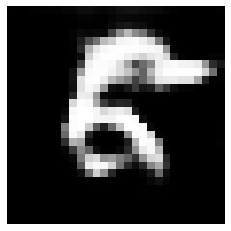

Time for epoch 52 is 31.060669660568237 sec


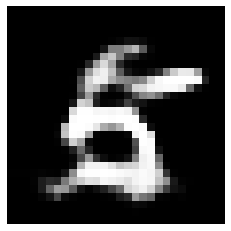

Time for epoch 53 is 29.575117349624634 sec


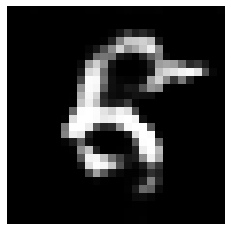

Time for epoch 54 is 29.156949520111084 sec


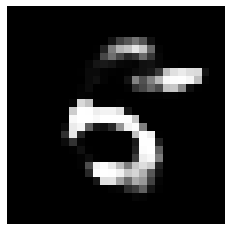

Time for epoch 55 is 34.08730602264404 sec


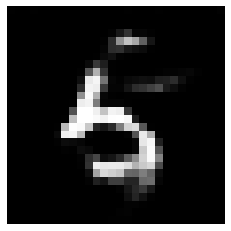

Time for epoch 56 is 35.897549867630005 sec


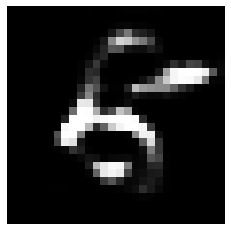

Time for epoch 57 is 33.321539640426636 sec


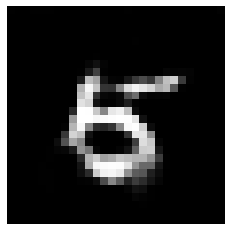

Time for epoch 58 is 28.808791160583496 sec


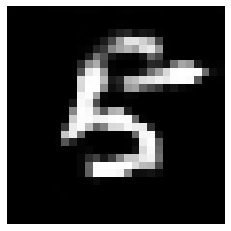

Time for epoch 59 is 28.976945638656616 sec


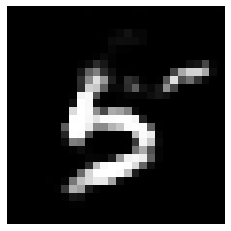

Time for epoch 60 is 28.800639629364014 sec


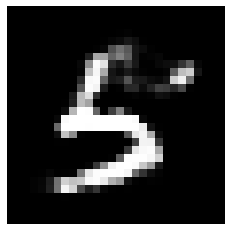

Time for epoch 61 is 31.76019835472107 sec


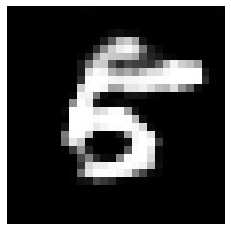

Time for epoch 62 is 30.271479606628418 sec


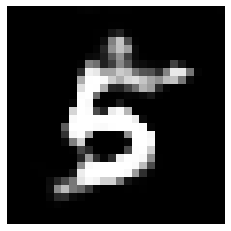

Time for epoch 63 is 29.278661012649536 sec


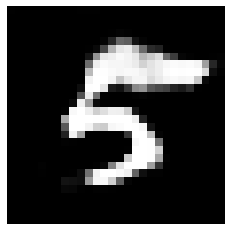

Time for epoch 64 is 28.674660682678223 sec


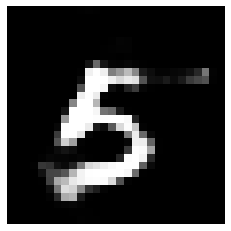

Time for epoch 65 is 29.452653884887695 sec


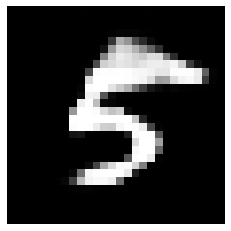

Time for epoch 66 is 31.47299861907959 sec


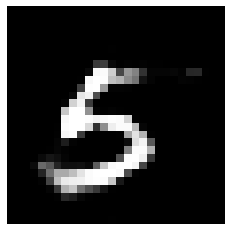

Time for epoch 67 is 30.421793937683105 sec


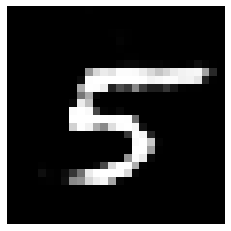

Time for epoch 68 is 32.06770849227905 sec


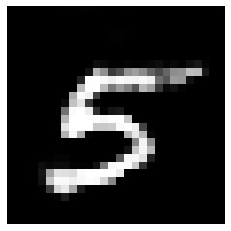

Time for epoch 69 is 29.081934690475464 sec


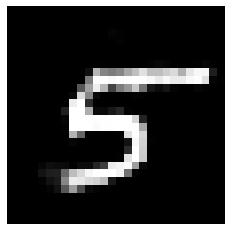

Time for epoch 70 is 28.91778016090393 sec


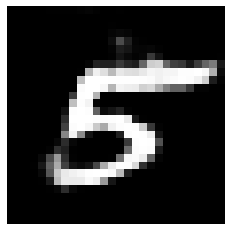

Time for epoch 71 is 28.944528579711914 sec


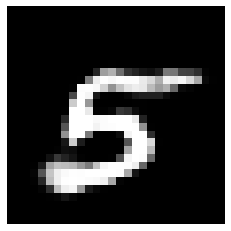

Time for epoch 72 is 34.03923416137695 sec


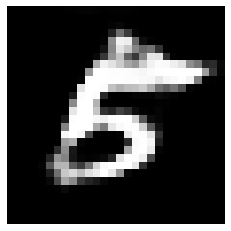

Time for epoch 73 is 30.427666187286377 sec


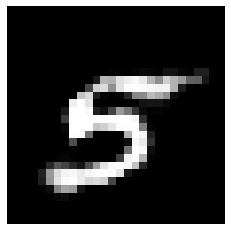

Time for epoch 74 is 29.239672899246216 sec


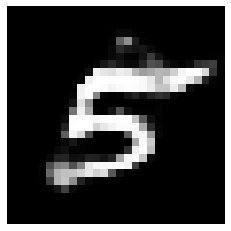

Time for epoch 75 is 32.05487084388733 sec


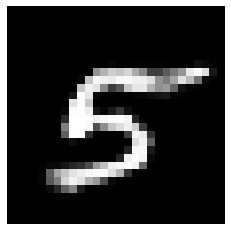

Time for epoch 76 is 29.45397925376892 sec


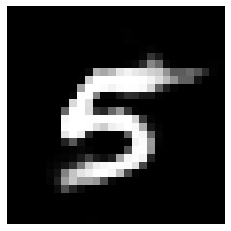

Time for epoch 77 is 31.810450553894043 sec


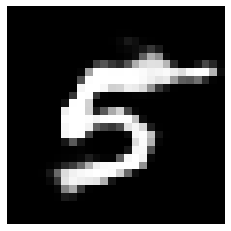

Time for epoch 78 is 31.34290909767151 sec


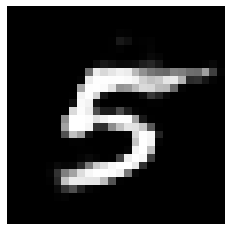

Time for epoch 79 is 30.448364973068237 sec


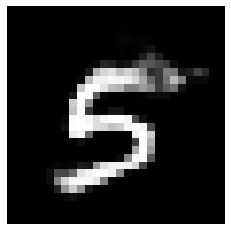

Time for epoch 80 is 30.160823822021484 sec


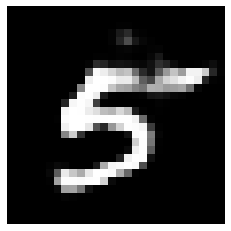

Time for epoch 81 is 28.813363313674927 sec


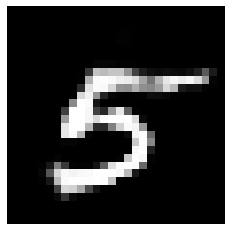

Time for epoch 82 is 29.144866466522217 sec


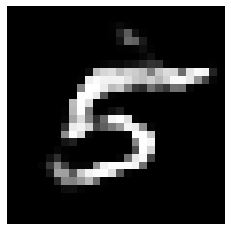

Time for epoch 83 is 29.071640253067017 sec


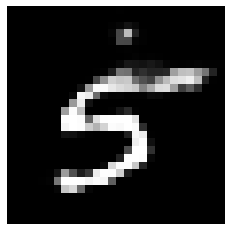

Time for epoch 84 is 29.75306010246277 sec


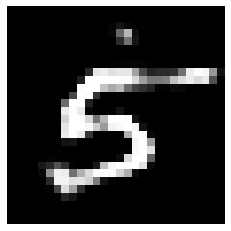

Time for epoch 85 is 29.695497751235962 sec


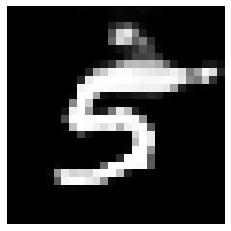

Time for epoch 86 is 32.60583734512329 sec


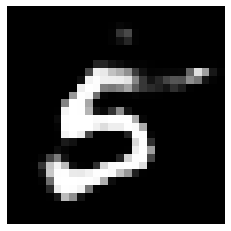

Time for epoch 87 is 32.50500464439392 sec


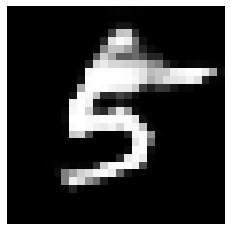

Time for epoch 88 is 29.85933542251587 sec


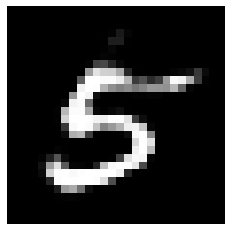

Time for epoch 89 is 29.121083974838257 sec


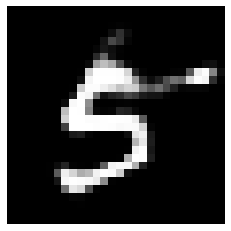

Time for epoch 90 is 31.314699411392212 sec


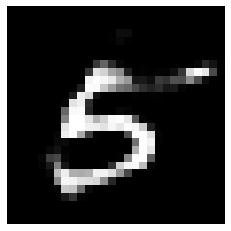

Time for epoch 91 is 30.898627042770386 sec


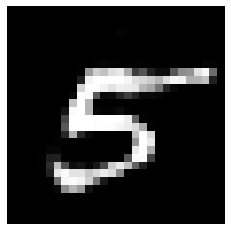

Time for epoch 92 is 29.255814790725708 sec


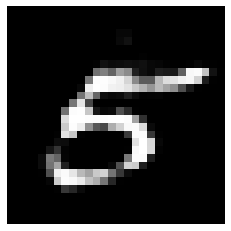

Time for epoch 93 is 33.22641038894653 sec


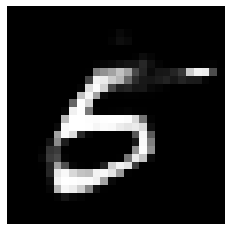

Time for epoch 94 is 31.807323217391968 sec


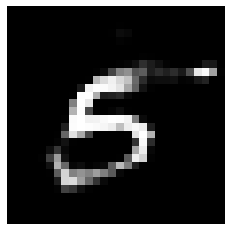

Time for epoch 95 is 28.27547001838684 sec


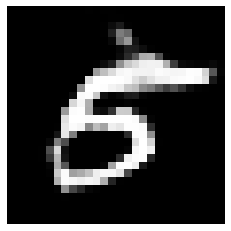

Time for epoch 96 is 32.07103204727173 sec


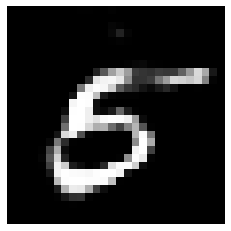

Time for epoch 97 is 29.650892734527588 sec


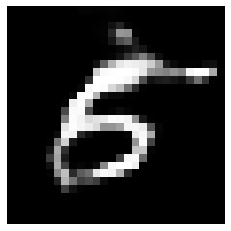

Time for epoch 98 is 33.39168643951416 sec


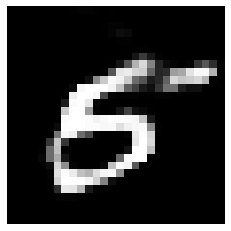

Time for epoch 99 is 32.2721734046936 sec


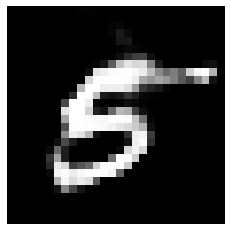

Time for epoch 100 is 34.887834548950195 sec


In [21]:
# The model training is now started with a call to this train method
train(train_dataset, EPOCHS)